# Leuschner Target List
Take our Google Sheets target list (as an Excel file) and export out in a format suitable for Jim Gibson to copy/paste coordinates.  Also sort the objects in an order that we will observe in at the telescope and have people ready to go when their time comes.

In [1]:
# Input Target List
input_file = 'expres_targets.csv' #
input_skiprows = 0 #how do you skip header?

# Name of output CSV file
output_csv = 'data/mar_16_leuschner_moon_distance.csv'

# Imports

In [2]:
# Import Numpy & Matplotlib as always

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
# For manipulating data files

from astropy.table import (
    Table,
    join,
)

import pandas
import numpy as np

In [4]:
# Catch or ignore warnings as we see fit (we want to catch a warning later)
import warnings

In [5]:
# Import some style support to make prettier plots

from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()
from astropy.visualization import time_support
time_support() 
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

In [6]:
# Import coordinate packages 

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.coordinates import SphericalDifferential

In [7]:
from astropy.coordinates import (
    get_sun,
    get_moon
)
from astropy.coordinates.errors import UnitsError, IllegalHourWarning

# Import Targets from Spreadsheet

In [8]:
try:
    targets_xls = pandas.read_csv(input_file,skiprows=input_skiprows)
    targets = Table.from_pandas(targets_xls)
except Exception as err:
    print("Unable to read in the input csv file: {}".format(err))

In [9]:
targets.show_in_notebook() ###

idx,target_name,target_ra_hms,target_dec_dms
0,3651,00 39 22.09,+21 15 04.90
1,4628,00 48 22.53,+05 17 00.20
2,9407,01 34 33.88,+68 56 52.3
3,10476,01 42 29.95,+20 16 12.5
4,10700,01 44 05.13,-15 56 22.4
5,16160,02 36 04.895,+06 53 12.75
6,17156,02 49 44.490,+71 45 11.60
7,18803,03 02 25.87,+26 36 34.70
8,22049,03 32 56.42,-09 27 29.9
9,26965,04 15 16.3196,-07 39 10.3404


## Define Observatory Location & Observation Times

In [10]:
tel = EarthLocation.from_geodetic(lon=-111.422515, lat=34.744305, height=2337.0*u.meter) ###using Lowell coordinates
tel.name = "LDT"

utcoffset = -7 * u.hour # Mountain Standard Time
local_midnight = Time('2021-03-31 00:00:00') - utcoffset # Remember that midnight is on the next day
obs_start = Time('2021-03-30 22:03:00') - utcoffset
obs_end = Time('2021-03-31 00:32:00') - utcoffset

print("Midnight: {}".format(local_midnight)) ###print times 
print("Obs start: {}".format(obs_start))
print("Obs end: {}".format(obs_end)) 

Midnight: 2021-03-31 07:00:00.000
Obs start: 2021-03-31 05:03:00.000
Obs end: 2021-03-31 07:32:00.000


In [11]:
import re

# We allow 'h' or 'd' in the declination even though it will always be degrees
# because sometimes people make typos...we will give a warning when it occurs though
radec_re = re.compile('([0-9]{2})[h\:\s]+([0-9]{2})[m\:\s]+([0-9]{2}[0-9\.]+)s{0,1}\s+([\+\-]{1}[0-9]{2})[dh\:\s]+([0-9]{2})[m\:\s]+([0-9]{2}[0-9\.]+)s{0,1}')

In [12]:
targets.rename_column('target_name', 'Star')

In [13]:
#target = SkyCoord("01h44m04.08s -15d56m14.9s", frame=ICRS, unit=(u.hourangle, u.deg), obstime='J2000.0')
#target.name = 'Tau Ceti'
#target = SkyCoord("08h27m36.78s +45d39m10.8s", frame=ICRS, unit=(u.hourangle, u.deg), obstime='J2000.0')
#target.name = 'HD 71148'

with warnings.catch_warnings():
    warnings.simplefilter('error')

    tObjs = []
    for t in targets:
        try:
            coords = "{} {}".format(t['target_ra_hms'],t['target_dec_dms'])
            skyObj = SkyCoord(coords, frame='icrs', unit=(u.hourangle, u.deg), obstime='J2000.0')
            print("{} OK".format(t['Star']))
            tObjs.append(skyObj)
        except (ValueError, IllegalHourWarning, Warning) as err:
            #print(err)
            radec = radec_re.search(t['ICRS Coords'])
            if radec:
                ra = "{:02.0f}h{:02.0f}m{:02.1f}s".format(float(radec.group(1)),float(radec.group(2)),float(radec.group(3)))
                dec = "{:02.0f}d{:02.0f}m{:02.1f}s".format(float(radec.group(4)),float(radec.group(5)),float(radec.group(6)))
                skyObj = SkyCoord("{}".format("{} {}".format(ra,dec), frame='ICRS', unit=(u.hourangle, u.deg), obstime='J2000.0'))
                print("{} WARNING - Possible position error: {}".format(t['Star'],radec.group(0)))
                tObjs.append(skyObj)
            else:
                print("Can't find RA/DEC {}: {}".format(t['Star'],err))
                tObjs.append(None)
        except Exception as err:
            print("Unable to import {}: {}".format(t['Star'],err))
            tObjs.append(None)
            

    targets['skyObj'] = tObjs


3651 OK
4628 OK
9407 OK
10476 OK
10700 OK
16160 OK
17156 OK
18803 OK
22049 OK
26965 OK
32147 OK
34411 OK
38858 OK
50692 OK
52711 OK
55575 OK
69830 OK
71148 OK
75732 OK
76151 OK
84737 OK
86728 OK
89269 OK
89744 OK
95128 OK
95735 OK
99491 OK
99492 OK
101501 OK
103095 OK
104304 OK
105631 OK
110897 OK
114783 OK
115617 OK
117043 OK
120066 OK
122064 OK
126053 OK
127334 OK
131511 OK
136923 OK
141004 OK
143761 OK
145675 OK
146233 OK
154345 OK
157214 OK
157347 OK
158259 OK
158633 OK
159222 OK
161797 OK
164922 OK
166620 OK
168009 OK
182488 OK
183756 OK
185144 OK
186408 OK
186427 OK
190404 OK
190406 OK
191785 OK
193664 OK
197076 OK
199960 OK
210277 OK
217014 OK
218868 OK
219134 OK
221354 OK


## Create Observing Window (to midnight with indicators for obs window)

In [14]:
obs_halfwidth = 8 * u.hour # hours

obs_window = np.linspace(-obs_halfwidth, obs_halfwidth, 200 )
obs_times = local_midnight + obs_window

frame_night = AltAz(obstime=obs_times, location=tel)

In [15]:
altaz = np.empty(len(targets),dtype=SkyCoord)
airmass = []

for idx,t in enumerate(targets):
    target = t['skyObj']
    
    if target:
        # Transform object to alt/az
        target_altaz = target.transform_to(frame_night)

        # Convert alt/az to airmass (The secant of the zenith angle)
        target_airmass = target_altaz.secz

        altaz[idx] = target_altaz
        airmass.append(target_airmass)
    else:
        airmass.append(None)

targets['altaz'] = altaz
targets['airmass'] = airmass
targets['moon_distance'] = np.empty(len(targets), dtype=type(0*u.deg)) ###create an empty array and fill with targets

### Get the Sun positions during the observing window

In [16]:
sun_positions = get_sun(obs_times)
sun_altaz = sun_positions.transform_to(frame_night)
sun_airmass = sun_altaz.secz

sunset_to_sunrise = (sun_altaz.alt <= 0)
civil_twilight = (sun_altaz.alt <= -6*u.deg)
nautical_twilight = (sun_altaz.alt <= -12*u.deg)
astro_twilight = (sun_altaz.alt <= -18*u.deg)

### Get the Moon positions during the observing window

In [17]:
moon_positions = get_moon(obs_times)

# Transform object to alt/az
moon_altaz = moon_positions.transform_to(frame_night)

# Convert alt/az to airmass (The secant of the zenith angle)
moon_airmass = moon_altaz.secz

moon_up = (moon_altaz.alt.value > 0)

In [18]:
# The Astropy timesupport converts everything to MJD
# We just add/subtract the UTC offset in days to the MJD date we are passed to convert from UTC<->Local
def UTC_to_LT( time ):
    return time + (utcoffset.to(u.day).value)

def LT_to_UTC( time ):
    return time - (utcoffset.to(u.day).value)

In [19]:
# set the time widow to 1 hour outside of sunset/sunrise
xlim = [obs_times[sunset_to_sunrise][0] - 1*u.hour,obs_times[sunset_to_sunrise][-1] + 1*u.hour]

In [20]:
# get our observing window times
in_obs_window = (obs_times <= obs_end) & (obs_times >= obs_start)

In [21]:
def fmt_time( t, pos=None ):
    return Time(t,format="mjd").strftime('%H:%M')

In [22]:
target_colors = ['#66FF00','#08E8DE','#FFF000','#FFAA1D','#FF007F','#91AAFF','#FF9E9E','#FF80C5','#7AFBFF','#8AFF9C']
moon_color = '#FFFF00'
sun_color = '#CC6600'

def t_color(idx):
    return target_colors[idx % len(target_colors)]

In [23]:
ra_hms = []
dec_dms = []

for t in targets:
    try:
        tmp = t['skyObj']
        # We only want coords shown to the nearest arcminute, so round the dec arcminutes
        # and show the rounded seconds of RA
        #ra = "{:02.0f}h{:02.0f}m{:02.0f}s".format(tmp.ra.hms.h,tmp.ra.hms.m,tmp.ra.hms.s)
        #dec = "{h:02.0f}d{m:02.0f}m".format(h=tmp.dec.dms.d,m=abs(tmp.dec.dms.m)+abs(tmp.dec.dms.s)/60,s=abs(tmp.dec.dms.s))
        ra = "{:02.0f}:{:02.0f}:{:02.0f}".format(tmp.ra.hms.h,tmp.ra.hms.m,tmp.ra.hms.s)
        dec = "{h:02.0f}:{m:02.0f}".format(h=tmp.dec.dms.d,m=abs(tmp.dec.dms.m)+abs(tmp.dec.dms.s)/60,s=abs(tmp.dec.dms.s))
    except Exception as err:
        ra = ''
        dec = ''
    ra_hms.append(ra)
    dec_dms.append(dec)

targets['ra'] = ra_hms
targets['dec'] = dec_dms

sortorder = np.argsort(targets['ra'])

targets = targets[sortorder]

3651 not observable
4628 not observable
9407 airmass > 1.4 during obs window, not plotted.
10476 not observable
10700 not observable
16160 not observable
17156 airmass > 1.4 during obs window, not plotted.
18803 not observable
22049 not observable
26965 not observable
32147 not observable
34411 airmass > 1.4 during obs window, not plotted.
38858 not observable
69830 airmass > 1.4 during obs window, not plotted.
76151 airmass > 1.4 during obs window, not plotted.
104304 airmass > 1.4 during obs window, not plotted.
114783 too close to moon: 27.786593557225043 deg
115617 airmass > 1.4 during obs window, not plotted.
120066 too close to moon: 26.642146553865846 deg
126053 too close to moon: 17.469000769568 deg
141004 airmass > 1.4 during obs window, not plotted.
146233 airmass > 1.4 during obs window, not plotted.
154345 airmass > 1.4 during obs window, not plotted.
157214 airmass > 1.4 during obs window, not plotted.
157347 not observable
158633 airmass > 1.4 during obs window, not plott

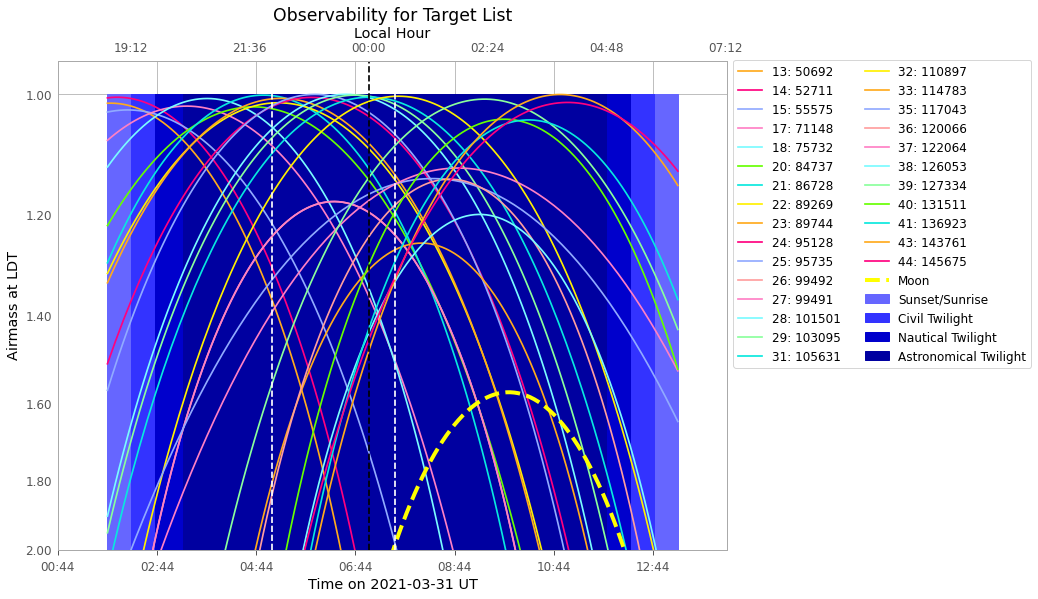

In [24]:
fig, ax = plt.subplots(1,1, figsize=[12,9])

# Set the time window for the plot
ax.set_xlim(xlim)
ax.set_ylim(0.95,2) # airmass

# Draw the background for the sunset, 6°, 12°, and 18° twilight regions
at_night = ax.fill_between(obs_times[sunset_to_sunrise],1.0,3.0,color="#6666FF", label="Sunset/Sunrise")
at_civil_twilight = ax.fill_between(obs_times[civil_twilight],1.0,3.0,color="#3333FF", label="Civil Twilight")
at_nautical_twilight = ax.fill_between(obs_times[nautical_twilight],1.0,3.0,color="#0000CC", label="Nautical Twilight")
at_astro_twilight = ax.fill_between(obs_times[astro_twilight],1.0,3.0,color="#0000A0", label="Astronomical Twilight")

# Set the Axis Labels
ax.set_xlabel('Time on {} UT'.format(local_midnight.strftime("%Y-%m-%d")))
ax.set_ylabel('Airmass at {}'.format(tel.name))
ax.set_title('Observability for Target List')

# Set axis formatting (UTC Time for x, inverted log scale for y)
ax.set_xticks(np.arange(xlim[0].mjd,xlim[1].mjd,1/12)) # every 2 hours
ax.xaxis.set_major_formatter(FuncFormatter(fmt_time))
ax.tick_params('x', direction='out', length=5, width=1, which='both')

ax.set_yscale('log')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.2f'))
ax.invert_yaxis()

# Add a second x axis to plot the Local Time
second_ax = ax.secondary_xaxis('top',functions=(UTC_to_LT,LT_to_UTC))
second_ax.xaxis.set_major_formatter(FuncFormatter(fmt_time))
l = second_ax.set_xlabel('Local Hour')

# Plot our target
for idx,target in enumerate(targets):
    #if 'Niah' not in target['Owner Name']: continue
    try:
        star_up = (target['altaz'].alt >= 20*u.deg)
        max_height_idx = np.where(target['altaz'].alt == np.max(target['altaz'].alt))[0]
        
        target['moon_distance'] = np.min(target['altaz'][in_obs_window].separation(moon_positions[in_obs_window]))
        
        if ( np.sum(star_up & in_obs_window) == 0):
            print("{} not observable".format(target['Star']))
            continue
        elif ( np.min(target['airmass'][in_obs_window & star_up]) >= 1.4):
            print("{} airmass > 1.4 during obs window, not plotted.".format(target['Star']))
            continue
        
        if target['moon_distance'] < 30.0 * u.deg:
            linestyle = '--'
            print("{} too close to moon: {}". format(target['Star'], target['moon_distance']))
        else:
            linestyle = '-'
                                                    
        p_target = ax.plot(obs_times[star_up & sunset_to_sunrise],target['airmass'][star_up & sunset_to_sunrise],
                           color=t_color(idx),label="{:02}: {}".format(idx,target['Star']))
    except Exception as err:
        print("Unable to determine star altitudes: {}".format(err))
        pass

# Plot the Moon
p_moon = ax.plot(obs_times[moon_up],moon_airmass[moon_up],linestyle='--',linewidth=4, color=moon_color,label="Moon")

# Plot the Sun (won't show unless airmass window is generous)
p_sun = ax.plot(obs_times[~sunset_to_sunrise],sun_airmass[~sunset_to_sunrise],color=sun_color)

p_local_midnight = ax.axvline(local_midnight.mjd,linestyle='--',color='black')
p_start = ax.axvline((obs_start).mjd,linestyle='--',color='white') # 6:30pm local
p_end = ax.axvline((obs_end).mjd,linestyle='--',color='white') # 9:15pm local

l = fig.legend(bbox_to_anchor=(0.9, 0.89), ncol=2, loc='upper left')

In [25]:
s = targets[targets['Star'] == 'e Geminorum B'][0]

/Users/carissaavina-beltran/opt/anaconda3/envs/astr470/lib/python3.8/site-packages/astropy/table/column.py:1152: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


In [26]:
pm_ra = 89.234 * u.mas/u.year
pm_dec = -77.171 * u.mas/u.year

#proper_motion = SphericalDifferential(d_lon=pm_ra, d_lat=pm_dec, d_distance=0*u.km/u.s)
#d_motion = s['skyObj'].data.with_differentials(proper_motion)
#s['skyObj'] = s['skyObj'].realize_frame(d_motion)

In [27]:
#print("J2000: {}".format(s['skyObj']))
#print("Feb 16 2021: {}".format(SkyCoord(s['skyObj'],obstime=Time('2000-01-01')).apply_space_motion(new_obstime=Time('2021-02-17 02:46:00.0'))))

In [28]:
data = targets[['Star','ra','dec','V mag','U','B','V','R','I','Owner Name']]
data['target_num'] = np.linspace(1,len(data),len(data))

# Replace bogus Exposure Numbers
for col in ['U','B','V','R','I']:
    data[col][(data[col] - np.floor(data[col]) != 0)] = 1
    data[col].info.format = '.0f'


KeyError: 'V mag'

In [28]:
data.show_in_notebook()

idx,Star,ra,dec,V mag,U,B,V,R,I,Owner Name,target_num
0,HD 16209,02:37:14,38:59,9.86,0,1,1,0,0,Ryan Robinson,1.0
1,TYC 2351-832-1,03:05:40,36:06,10.92,0,1,1,0,0,Aishwarya Balivada,2.0
2,SAO 56175,03:07:29,36:37,9.13,0,1,1,0,0,Aishwarya Balivada,3.0
3,HD 278265,03:07:45,36:52,9.49,0,1,1,0,0,Ryan Robinson,4.0
4,HD 278328,03:10:25,36:34,9.69,0,1,1,0,0,Dilpreet Kaur,5.0
5,HD 275115,03:15:22,38:25,11.31,0,1,1,0,0,Dilpreet Kaur,6.0
6,16 Tauri,03:44:48,24:17,5.46,0,1,1,0,0,Mathew Chew,7.0
7,BD+25 604,03:45:07,25:33,9.99,0,1,1,0,0,Noel Ibarra,8.0
8,HD 23339,03:45:14,23:07,9.81,0,2,2,0,0,William Mosley,9.0
9,V* MM Per,03:45:23,48:05,10.93,0,1,2,0,0,Yatrik Patel,10.0


In [30]:
data.write(output_csv,format='csv',overwrite=True)

## Input & Output filenames
